### Init

In [1]:
import os
import argparse

import torch
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio
from os2d.data import dataloader
from os2d.modeling.model import build_os2d_from_config

from os2d.data.dataloader import build_eval_dataloaders_from_cfg, build_train_dataloader_from_config
from os2d.engine.train import trainval_loop
from os2d.utils import set_random_seed, get_trainable_parameters, mkdir, save_config, setup_logger, get_data_path
from os2d.engine.optimization import create_optimizer
from os2d.config import cfg
from os2d.utils.visualization import *
import random
import os2d.utils.visualization as visualizer
from pathlib import Path
import cv2
import numpy as np
from os2d.utils import get_image_size_after_resize_preserving_aspect_ratio
from src.util.detection import generate_detection_boxes
from src.util.visualize import visualize_boxes_on_image
from src.util.filter import DataLoaderDB

In [2]:
if cfg.is_cuda:
    assert torch.cuda.is_available(), "Do not have available GPU, but cfg.is_cuda == 1"
    torch.backends.cudnn.benchmark = True

# random seed
set_random_seed(cfg.random_seed, cfg.is_cuda)

# Model
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)

# Optimizer
parameters = get_trainable_parameters(net)
optimizer = create_optimizer(parameters, cfg.train.optim, optimizer_state)

# load the dataset
data_path = get_data_path()
dataloader_train, datasets_train_for_eval = build_train_dataloader_from_config(cfg, box_coder, img_normalization,
                                                                                data_path=data_path)

dataloaders_eval = build_eval_dataloaders_from_cfg(cfg, box_coder, img_normalization,
                                                    datasets_for_eval=datasets_train_for_eval,
                                                    data_path=data_path)

db = DataLoaderDB( path = './src/db/data.csv' , dataloader = dataloader_train)

### Test Basic Method of DB

In [3]:
image_ids = list ( map( int , db.get_image_ids()) )
sorted_image_ids = sorted(image_ids)
print( sorted_image_ids )

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 201, 202, 203, 207, 209, 210, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 2

In [4]:
db.get_class_ids_by_image_id(0)

{'0': 3, '1': 3, '2': 2, '3': 4, '4': 4, '5': 3, '6': 3, '7': 2, '1055': 6}

In [5]:
len(db.get_value_by_id( 10 , 42 ))

13

### Test Basic Method of ContextAoiAlign

In [6]:
from src.lcp.ct_aoi_align import ContextAoiAlign
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

context_aoi_align = ContextAoiAlign( db, dataloader_train, transform_image , net , cfg )

In [7]:
# context_aoi_align.compute_roi_region_for_all()

In [8]:
context_aoi_align.get_feature_map( 0 )

tensor([[[2.6359, 0.7501, 0.5805,  ..., 0.2295, 0.4535, 1.1069],
         [0.6802, 0.3717, 0.0000,  ..., 0.2353, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2768, 0.5063, 0.0000,  ..., 0.3253, 0.7125, 0.0000],
         [0.3378, 0.0000, 0.0000,  ..., 0.0000, 0.7866, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0829, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.2380, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 2.5919, 3.4586, 0.4234],
         [0.0000, 0.0000, 0.0000,  ..., 0.7022, 1.2554, 0.0000]],

        [[0.0000, 0.6587, 0.0000,  ..., 0.0000, 1.6693, 2.2038],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.3089, 1.7788],
         [0.0000, 0.3178, 0.0000,  ..., 0.0000, 0.9639, 1.

In [9]:
context_aoi_align.get_feature_map( 0 ).shape

torch.Size([1024, 82, 109])

In [10]:
context_aoi_align.get_feature_map_no_grad( 0 )

tensor([[[2.6359, 0.7501, 0.5805,  ..., 0.2295, 0.4535, 1.1069],
         [0.6802, 0.3717, 0.0000,  ..., 0.2353, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2768, 0.5063, 0.0000,  ..., 0.3253, 0.7125, 0.0000],
         [0.3378, 0.0000, 0.0000,  ..., 0.0000, 0.7866, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0829, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.2380, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 2.5919, 3.4586, 0.4234],
         [0.0000, 0.0000, 0.0000,  ..., 0.7022, 1.2554, 0.0000]],

        [[0.0000, 0.6587, 0.0000,  ..., 0.0000, 1.6693, 2.2038],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.3089, 1.7788],
         [0.0000, 0.3178, 0.0000,  ..., 0.0000, 0.9639, 1.

In [11]:
context_aoi_align.get_feature_map_no_grad( 0 ).shape

torch.Size([1024, 82, 109])

In [12]:
# context_aoi_align.extract_roi_features_by_ids( 0 , 0 )

In [13]:
context_aoi_align.extract_roi_features_by_ids_in_no_grad( 0, 0 )

[{'image_id': 0,
  'class_id': 0,
  'truth_box': ((350.8800048828125, 0.0),
   (767.0399780273438, 595.598388671875)),
  'context_roi': ((350.8800048828125, 0.0),
   (783.6328192660219, 626.5802359988452)),
  'features': {'truth_feature': tensor([[[4.2222e-01, 0.0000e+00, 5.6205e-02,  ..., 7.1005e-01,
             6.0172e-01, 1.6310e+00],
            [4.9514e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             4.1607e-02, 5.1353e-01],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 3.1874e-02],
            ...,
            [1.5927e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00]],
   
           [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
       

In [14]:
context_aoi_align.roi_align( 0 , 0 , 
                            (350.8800048828125, 0.0) , (767.0399780273438, 595.598388671875), 
                            (350.8800048828125, 0.0) , (783.6328192660219, 626.5802359988452) 
                            )

{'truth_feature': tensor([[[4.2222e-01, 0.0000e+00, 5.6205e-02,  ..., 7.1005e-01,
           6.0172e-01, 1.6310e+00],
          [4.9514e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           4.1607e-02, 5.1353e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 3.1874e-02],
          ...,
          [1.5927e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000

In [15]:
context_aoi_align.extract_roi_align_no_grad( 0 , 0 , 
                                            (350.8800048828125, 0.0) , (767.0399780273438, 595.598388671875), 
                                            (350.8800048828125, 0.0) , (783.6328192660219, 626.5802359988452) 
                                            )

{'truth_feature': tensor([[[4.2222e-01, 0.0000e+00, 5.6205e-02,  ..., 7.1005e-01,
           6.0172e-01, 1.6310e+00],
          [4.9514e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           4.1607e-02, 5.1353e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 3.1874e-02],
          ...,
          [1.5927e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000

In [16]:
# context_aoi_align.extract_roi_features_for_all()

In [17]:
from src.lcp.aux_net import AuxiliaryNetwork
aux_net = AuxiliaryNetwork( context_aoi_align, db )

In [18]:
point1_x = float( db.get_specific_data(0 , 0 , 'point1_x' )[0] )
point1_y = float( db.get_specific_data(0 , 0 , 'point1_y' )[0] )
point2_x = float( db.get_specific_data(0 , 0 , 'point2_x' )[0] )
point2_y = float( db.get_specific_data(0 , 0 , 'point2_y' )[0] )   

point1 = ( point1_x , point1_y )
point2 = ( point2_x , point2_y )
image_id = 0
class_id = 0 
m = 5

In [19]:
print("=== Ê∏¨Ë©¶ÂõûÊ≠∏ÊêçÂ§±Ëøë‰ººÂáΩÊï∏ ===")
ar_loss = aux_net.approximate_ar_loss_no_grad(image_id, class_id, point1, point2, m = 3)
print(f"Image {image_id}, Class {class_id}: AR Loss = {ar_loss:.4f}")
print(f"ËøîÂõûÈ°ûÂûã: {type(ar_loss)}")
print(f"Êï∏ÂÄºÊ™¢Êü•: {'‚úì Ê≠£Â∏∏' if ar_loss >= 0 else '‚úó Áï∞Â∏∏'}")

=== Ê∏¨Ë©¶ÂõûÊ≠∏ÊêçÂ§±Ëøë‰ººÂáΩÊï∏ ===
Image 0, Class 0: AR Loss = 0.8786
ËøîÂõûÈ°ûÂûã: <class 'float'>
Êï∏ÂÄºÊ™¢Êü•: ‚úì Ê≠£Â∏∏


In [20]:
print("\n=== Ê∏¨Ë©¶ÂàÜÈ°ûÊêçÂ§±Ëøë‰ººÂáΩÊï∏ ===")
ac_loss = aux_net.approximate_ac_loss_no_grad(image_id, class_id, point1, point2)
print(f"Image {image_id}, Class {class_id}: AC Loss = {ac_loss:.4f}")
print(f"ËøîÂõûÈ°ûÂûã: {type(ac_loss)}")
print(f"Êï∏ÂÄºÊ™¢Êü•: {'‚úì Ê≠£Â∏∏' if ac_loss >= 0 else '‚úó Áï∞Â∏∏'}")


=== Ê∏¨Ë©¶ÂàÜÈ°ûÊêçÂ§±Ëøë‰ººÂáΩÊï∏ ===
Image 0, Class 0: AC Loss = 0.4542
ËøîÂõûÈ°ûÂûã: <class 'float'>
Êï∏ÂÄºÊ™¢Êü•: ‚úì Ê≠£Â∏∏


In [21]:
# Ê∏¨Ë©¶ Context RoI Align Êï¥Âêà
print("\n=== Ê∏¨Ë©¶ Context RoI Align Êï¥Âêà ===")

# 1. Ê∏¨Ë©¶ Context ROI Áç≤Âèñ
context_roi_point1, context_roi_point2 = aux_net._context_roi_align._get_roi_region_specific(
    image_id, class_id, point1, point2
)
print(f"Context ROI: {context_roi_point1} -> {context_roi_point2}")

# 2. Ê∏¨Ë©¶ÁâπÂæµÊèêÂèñ
contextual_features = aux_net._context_roi_align.extract_roi_align_no_grad(
    image_id, class_id, point1, point2,
    context_roi_point1, context_roi_point2
)

if contextual_features:
    print(f"ÁâπÂæµÊèêÂèñ: ‚úì ÊàêÂäü")
    combined_feature = contextual_features['combined_feature']
    print(f"ÁâπÂæµÁ∂≠Â∫¶: {combined_feature.shape}")
    
    import torch
    print(f"ÁâπÂæµÁµ±Ë®à: mean={torch.mean(combined_feature):.4f}, std={torch.std(combined_feature):.4f}")
else:
    print("ÁâπÂæµÊèêÂèñ: ‚úó Â§±Êïó")



=== Ê∏¨Ë©¶ Context RoI Align Êï¥Âêà ===
Context ROI: (350.8800048828125, 0.0) -> (783.6328192660219, 626.5802359988452)
ÁâπÂæµÊèêÂèñ: ‚úì ÊàêÂäü
ÁâπÂæµÁ∂≠Â∫¶: torch.Size([1024, 7, 7])
ÁâπÂæµÁµ±Ë®à: mean=0.8192, std=1.5051


In [22]:
# ÊÄßËÉΩÊ∏¨Ë©¶
import time

print("\n=== ÊÄßËÉΩÊ∏¨Ë©¶ ===")

# Ê∏¨Ë©¶Âü∑Ë°åÊôÇÈñì
iterations = 5
start_time = time.time()

for i in range(iterations):
    ar_loss = aux_net.approximate_ar_loss_no_grad(image_id, class_id, point1, point2)
    ac_loss = aux_net.approximate_ac_loss_no_grad(image_id, class_id, point1, point2)

end_time = time.time()
avg_time = (end_time - start_time) / iterations

print(f"Âπ≥ÂùáÂü∑Ë°åÊôÇÈñì: {avg_time:.4f} Áßí")
print(f"Âü∑Ë°å {iterations} Ê¨°Á∏ΩÊôÇÈñì: {end_time - start_time:.4f} Áßí")



=== ÊÄßËÉΩÊ∏¨Ë©¶ ===
Âπ≥ÂùáÂü∑Ë°åÊôÇÈñì: 10.4499 Áßí
Âü∑Ë°å 5 Ê¨°Á∏ΩÊôÇÈñì: 52.2497 Áßí


In [23]:
# Ë©≥Á¥∞Ë™øË©¶
print("\n=== Ë©≥Á¥∞Ë™øË©¶Âü∑Ë°å ===")

print(f"Ëº∏ÂÖ•ÂèÉÊï∏: image_id={image_id}, class_id={class_id}")
print(f"ÈÇäÁïåÊ°Ü: {point1} -> {point2}")

# Ê≠•È©ü 1: Context ROI Áç≤Âèñ
print("\nÊ≠•È©ü 1: Context ROI Áç≤Âèñ")
context_roi_point1, context_roi_point2 = aux_net._context_roi_align._get_roi_region_specific(
    image_id, class_id, point1, point2
)
print(f"ÁµêÊûú: {context_roi_point1} -> {context_roi_point2}")

# Ê≠•È©ü 2: ÁâπÂæµÊèêÂèñ
print("\nÊ≠•È©ü 2: ÁâπÂæµÊèêÂèñ")
contextual_features = aux_net._context_roi_align.extract_roi_align_no_grad(
    image_id, class_id, point1, point2,
    context_roi_point1, context_roi_point2
)

if contextual_features:
    combined_feature = contextual_features['combined_feature']
    print(f"ÁâπÂæµÁ∂≠Â∫¶: {combined_feature.shape}")
    
    import torch
    global_mean = torch.mean(combined_feature)
    global_std = torch.std(combined_feature)
    print(f"ÂÖ®ÂüüÁµ±Ë®à: mean={global_mean:.4f}, std={global_std:.4f}")
    
    # Ê≠•È©ü 3: Áµ±Ë®àË®àÁÆó
    print("\nÊ≠•È©ü 3: Áµ±Ë®àË®àÁÆó")
    C, H, W = combined_feature.shape
    channel_means = torch.mean(combined_feature.view(C, -1), dim=1)
    mean_deviations = torch.abs(channel_means - global_mean)
    localization_sensitivity = torch.mean(mean_deviations) / (global_std + 1e-8)
    print(f"ÂÆö‰ΩçÊïèÊÑüÊÄß: {localization_sensitivity:.4f}")

# Ê≠•È©ü 4: GIoU Áµ±Ë®à
print("\nÊ≠•È©ü 4: GIoU Áµ±Ë®à")
giou_stats = aux_net._compute_giou_statistics(image_id, class_id)
print(f"GIoU Áµ±Ë®à: {giou_stats}")

# Ê≠•È©ü 5: ÊúÄÁµÇÊêçÂ§±Ë®àÁÆó
print("\nÊ≠•È©ü 5: ÊúÄÁµÇÊêçÂ§±Ë®àÁÆó")
ar_loss = aux_net.approximate_ar_loss_no_grad(image_id, class_id, point1, point2, m = 3)
ac_loss = aux_net.approximate_ac_loss_no_grad(image_id, class_id, point1, point2)
print(f"AR Loss: {ar_loss:.4f}")
print(f"AC Loss: {ac_loss:.4f}")
print(f"Total: {ar_loss + ac_loss:.4f}")



=== Ë©≥Á¥∞Ë™øË©¶Âü∑Ë°å ===
Ëº∏ÂÖ•ÂèÉÊï∏: image_id=0, class_id=0
ÈÇäÁïåÊ°Ü: (350.8800048828125, 0.0) -> (767.0399780273438, 595.598388671875)

Ê≠•È©ü 1: Context ROI Áç≤Âèñ
ÁµêÊûú: (350.8800048828125, 0.0) -> (783.6328192660219, 626.5802359988452)

Ê≠•È©ü 2: ÁâπÂæµÊèêÂèñ
ÁâπÂæµÁ∂≠Â∫¶: torch.Size([1024, 7, 7])
ÂÖ®ÂüüÁµ±Ë®à: mean=0.8192, std=1.5051

Ê≠•È©ü 3: Áµ±Ë®àË®àÁÆó
ÂÆö‰ΩçÊïèÊÑüÊÄß: 0.4103

Ê≠•È©ü 4: GIoU Áµ±Ë®à
GIoU Áµ±Ë®à: {'mean': 0.8587324282294295, 'std': 0.04220323204537694, 'count': 3}

Ê≠•È©ü 5: ÊúÄÁµÇÊêçÂ§±Ë®àÁÆó
AR Loss: 0.8786
AC Loss: 0.4542
Total: 1.3329


#### Test for LCP

In [24]:
from src.lcp.lcp import LCP


In [25]:
lcp = LCP(net, aux_net, dataloader_train)
lcp.init_for_indices()

[LCP] ÂàùÂßãÂåñÂÆåÊàêÔºåÂÖ± 43 Â±§ÁöÑ channel Á¥¢Âºï


In [26]:
img_tensor = lcp.get_image_tensor_from_dataloader(image_id=0)


In [27]:
layers = lcp.get_layers_name()
for name, ch in layers:
    print(f"{name}: {ch} channels")

conv1: 64 channels
layer1.0.conv1: 64 channels
layer1.0.conv2: 64 channels
layer1.0.conv3: 256 channels
layer1.0.downsample.0: 256 channels
layer1.1.conv1: 64 channels
layer1.1.conv2: 64 channels
layer1.1.conv3: 256 channels
layer1.2.conv1: 64 channels
layer1.2.conv2: 64 channels
layer1.2.conv3: 256 channels
layer2.0.conv1: 128 channels
layer2.0.conv2: 128 channels
layer2.0.conv3: 512 channels
layer2.0.downsample.0: 512 channels
layer2.1.conv1: 128 channels
layer2.1.conv2: 128 channels
layer2.1.conv3: 512 channels
layer2.2.conv1: 128 channels
layer2.2.conv2: 128 channels
layer2.2.conv3: 512 channels
layer2.3.conv1: 128 channels
layer2.3.conv2: 128 channels
layer2.3.conv3: 512 channels
layer3.0.conv1: 256 channels
layer3.0.conv2: 256 channels
layer3.0.conv3: 1024 channels
layer3.0.downsample.0: 1024 channels
layer3.1.conv1: 256 channels
layer3.1.conv2: 256 channels
layer3.1.conv3: 1024 channels
layer3.2.conv1: 256 channels
layer3.2.conv2: 256 channels
layer3.2.conv3: 1024 channels
layer

In [28]:
layer_name = 'net_feature_maps.layer3.2.conv2'  # Ê†πÊìöÊÇ®ÁöÑÁ∂≤Ë∑ØÊû∂ÊßãË™øÊï¥
lambda_rate = 1.0
use_image_num = 3  # ‰ΩøÁî®Â∞ëÈáèÂúñÂÉèÈÄ≤Ë°åÊ∏¨Ë©¶

print(f"Ê∏¨Ë©¶Â±§: {layer_name}")
print(f"Lambda Áéá: {lambda_rate}")
print(f"‰ΩøÁî®ÂúñÂÉèÊï∏: {use_image_num}")

Ê∏¨Ë©¶Â±§: net_feature_maps.layer3.2.conv2
Lambda Áéá: 1.0
‰ΩøÁî®ÂúñÂÉèÊï∏: 3


In [29]:
# Ê™¢Êü•Ë®≠ÂÇô‰∏ÄËá¥ÊÄß
print("=== Ë®≠ÂÇô‰∏ÄËá¥ÊÄßÊ™¢Êü• ===")

# Ê™¢Êü•Á∂≤Ë∑ØË®≠ÂÇô
net_device = next(lcp._net.parameters()).device
prune_net_device = next(lcp._prune_net.parameters()).device

print(f"‰∏ªÁ∂≤Ë∑ØË®≠ÂÇô: {net_device}")
print(f"Ââ™ÊûùÁ∂≤Ë∑ØË®≠ÂÇô: {prune_net_device}")

# Ê™¢Êü•ÂúñÂÉèÂºµÈáèË®≠ÂÇô
img_tensor = lcp.get_image_tensor_from_dataloader(0, is_cuda=False)
print(f"ÂúñÂÉèÂºµÈáèË®≠ÂÇô: {img_tensor.device}")


=== Ë®≠ÂÇô‰∏ÄËá¥ÊÄßÊ™¢Êü• ===
‰∏ªÁ∂≤Ë∑ØË®≠ÂÇô: cpu
Ââ™ÊûùÁ∂≤Ë∑ØË®≠ÂÇô: cpu
ÂúñÂÉèÂºµÈáèË®≠ÂÇô: cuda:0


In [30]:
# # Âü∑Ë°åÁÑ°Ê¢ØÂ∫¶ÈÄöÈÅìÈáçË¶ÅÊÄßË®àÁÆó
# print("\n=== Âü∑Ë°åÁÑ°Ê¢ØÂ∫¶ÈÄöÈÅìÈáçË¶ÅÊÄßË®àÁÆó ===")

# try:
#     importance_scores = lcp.compute_channel_importance_no_grad(
#         layer_name=layer_name,
#         lambda_rate=lambda_rate,
#         use_image_num=use_image_num,
#         random_seed=42
#     )
    
#     print(f"‚úÖ Ë®àÁÆóÊàêÂäüÔºÅ")
#     print(f"ÈÄöÈÅìÊï∏Èáè: {len(importance_scores)}")
#     print(f"ÈáçË¶ÅÊÄßÂàÜÊï∏ÁØÑÂúç: {np.min(importance_scores):.4f} - {np.max(importance_scores):.4f}")
#     print(f"Âπ≥ÂùáÈáçË¶ÅÊÄß: {np.mean(importance_scores):.4f}")
#     print(f"Ê®ôÊ∫ñÂ∑Æ: {np.std(importance_scores):.4f}")
    
#     # È°ØÁ§∫Ââç10ÂÄãÈÄöÈÅìÁöÑÈáçË¶ÅÊÄß
#     print(f"\nÂâç10ÂÄãÈÄöÈÅìÈáçË¶ÅÊÄßÂàÜÊï∏:")
#     for i in range(min(10, len(importance_scores))):
#         print(f"  ÈÄöÈÅì {i}: {importance_scores[i]:.4f}")
        
# except Exception as e:
#     print(f"‚ùå Ë®àÁÆóÂ§±Êïó: {e}")
#     import traceback
#     traceback.print_exc()


In [31]:
# # Ê∏¨Ë©¶ÂêÑÂÄãÁµÑ‰ª∂ÂäüËÉΩ
# print("\n=== Ë©≥Á¥∞ÁµÑ‰ª∂Ê∏¨Ë©¶ ===")

# # Ê∏¨Ë©¶ÂúñÂÉèÊï∏ÊìöÊ∫ñÂÇô
# image_id_all = list(map(int, lcp._get_db().get_image_ids()))
# print(f"Á∏ΩÂúñÂÉèÊï∏: {len(image_id_all)}")
# print(f"Ââç5ÂÄãÂúñÂÉèID: {image_id_all[:5]}")

# # Ê∏¨Ë©¶ÂñÆÂÄãÂúñÂÉèÁöÑÁâπÂæµÁµ±Ë®àË®àÁÆó
# test_image_id = image_id_all[0]
# print(f"\nÊ∏¨Ë©¶ÂúñÂÉè {test_image_id} ÁöÑÁâπÂæµÁµ±Ë®à:")

# try:
#     feature_stats = lcp._extract_and_compute_theoretical_statistics(test_image_id, layer_name)
    
#     if feature_stats:
#         print(f"‚úÖ ÁâπÂæµÁµ±Ë®àË®àÁÆóÊàêÂäü")
#         print(f"ÈÄöÈÅìÊï∏: {len(feature_stats['channels'])}")
#         print(f"ÂÖ®ÂüüÁµ±Ë®à: mean={feature_stats['global_mean']:.4f}, std={feature_stats['global_std']:.4f}")
        
#         # È°ØÁ§∫Ââç3ÂÄãÈÄöÈÅìÁöÑË©≥Á¥∞Áµ±Ë®à
#         print(f"\nÂâç3ÂÄãÈÄöÈÅìË©≥Á¥∞Áµ±Ë®à:")
#         for i in range(min(3, len(feature_stats['channels']))):
#             ch_stat = feature_stats['channels'][i]
#             print(f"  ÈÄöÈÅì {i}:")
#             print(f"    L1ÁØÑÊï∏: {ch_stat['l1_norm']:.4f}")
#             print(f"    ÊñπÂ∑Æ: {ch_stat['variance']:.4f}")
#             print(f"    ÂùáÂÄºÂÅèÂ∑Æ: {ch_stat['mean_deviation']:.4f}")
#             print(f"    ËÉΩÈáè: {ch_stat['energy']:.4f}")
#             print(f"    Á®ÄÁñèÊÄß: {ch_stat['sparsity']:.4f}")
#             print(f"    ÈáçË¶ÅÊÄß: {ch_stat['importance']:.4f}")
#     else:
#         print("‚ùå ÁâπÂæµÁµ±Ë®àË®àÁÆóÂ§±Êïó")
        
# except Exception as e:
#     print(f"‚ùå ÁâπÂæµÁµ±Ë®àÊ∏¨Ë©¶Â§±Êïó: {e}")


In [32]:
# # È©óË≠âÊï∏Â≠∏ÂÖ¨ÂºèÂØ¶Áèæ
# print("\n=== Êï∏Â≠∏ÂÖ¨ÂºèÈ©óË≠â ===")

# if feature_stats:
#     # ÊâãÂãïÈ©óË≠âÁµ±ÂêàÂÖ¨Âºè
#     test_channel = feature_stats['channels'][0]
#     global_std = feature_stats['global_std']
    
#     # ÊâãÂãïË®àÁÆóÈáçË¶ÅÊÄßÂàÜÊï∏
#     manual_importance = (
#         0.3 * (test_channel['l1_norm'] / global_std) +                    # w1√óL1/œÉ
#         0.2 * (test_channel['variance'] / (global_std ** 2)) +            # w2√óVar/œÉ¬≤
#         0.2 * (test_channel['mean_deviation'] / global_std) +             # w3√ó|Œº-Œº_g|/œÉ
#         0.15 * (test_channel['energy'] / (global_std ** 2)) +             # w4√óE/œÉ¬≤
#         0.15 * (1.0 - test_channel['sparsity'])                           # w5√ó(1-sparsity)
#     )
    
#     computed_importance = test_channel['importance']
    
#     print(f"ÊâãÂãïË®àÁÆóÈáçË¶ÅÊÄß: {manual_importance:.6f}")
#     print(f"ÂáΩÊï∏Ë®àÁÆóÈáçË¶ÅÊÄß: {computed_importance:.6f}")
#     print(f"Â∑ÆÁï∞: {abs(manual_importance - computed_importance):.8f}")
#     print(f"ÂÖ¨ÂºèÈ©óË≠â: {'‚úÖ Ê≠£Á¢∫' if abs(manual_importance - computed_importance) < 1e-6 else '‚ùå ÈåØË™§'}")


In [33]:
# # ÊÄßËÉΩÊ∏¨Ë©¶
# print("\n=== ÊÄßËÉΩÊ∏¨Ë©¶ ===")

# import time
# import psutil
# import os

# process = psutil.Process(os.getpid())

# # Ê∏¨Ë©¶Âü∑Ë°åÊôÇÈñìÂíåË®òÊÜ∂È´î‰ΩøÁî®
# start_memory = process.memory_info().rss / 1024 / 1024  # MB
# start_time = time.time()

# # Âü∑Ë°åÂ§öÊ¨°Ê∏¨Ë©¶
# test_iterations = 3
# for i in range(test_iterations):
#     print(f"Âü∑Ë°åÁ¨¨ {i+1} Ê¨°Ê∏¨Ë©¶...")
#     importance_scores = lcp.compute_channel_importance_no_grad(
#         layer_name=layer_name,
#         lambda_rate=lambda_rate,
#         use_image_num=2,  # Ê∏õÂ∞ëÂúñÂÉèÊï∏‰ª•Âä†Âø´Ê∏¨Ë©¶
#         random_seed=42
#     )

# end_time = time.time()
# end_memory = process.memory_info().rss / 1024 / 1024  # MB

# avg_time = (end_time - start_time) / test_iterations
# memory_usage = end_memory - start_memory

# print(f"\nÊÄßËÉΩÁµ±Ë®à:")
# print(f"  Âπ≥ÂùáÂü∑Ë°åÊôÇÈñì: {avg_time:.4f} Áßí")
# print(f"  Ë®òÊÜ∂È´î‰ΩøÁî®Â¢ûÈáè: {memory_usage:.2f} MB")
# print(f"  Á∏ΩÂü∑Ë°åÊôÇÈñì: {end_time - start_time:.4f} Áßí")


In [34]:
# # ÈÄöÈÅìÈáçË¶ÅÊÄßÊéíÂ∫èÊ∏¨Ë©¶
# print("\n=== ÈÄöÈÅìÊéíÂ∫èÊ∏¨Ë©¶ ===")

# if 'importance_scores' in locals():
#     # Áç≤ÂèñÈáçË¶ÅÊÄßÊéíÂ∫è
#     sorted_indices = np.argsort(importance_scores)[::-1]  # ÈôçÂ∫èÊéíÂàó
    
#     print(f"ÊúÄÈáçË¶ÅÁöÑÂâç10ÂÄãÈÄöÈÅì:")
#     for i in range(min(10, len(sorted_indices))):
#         channel_idx = sorted_indices[i]
#         importance = importance_scores[channel_idx]
#         print(f"  ÊéíÂêç {i+1}: ÈÄöÈÅì {channel_idx} (ÈáçË¶ÅÊÄß: {importance:.4f})")
    
#     print(f"\nÊúÄ‰∏çÈáçË¶ÅÁöÑÂæå5ÂÄãÈÄöÈÅì:")
#     for i in range(max(0, len(sorted_indices)-5), len(sorted_indices)):
#         channel_idx = sorted_indices[i]
#         importance = importance_scores[channel_idx]
#         rank = len(sorted_indices) - i
#         print(f"  ÂÄíÊï∏Á¨¨ {rank}: ÈÄöÈÅì {channel_idx} (ÈáçË¶ÅÊÄß: {importance:.4f})")
    
#     # Áµ±Ë®àÂàÜÊûê
#     top_10_percent = int(len(importance_scores) * 0.1)
#     top_scores = importance_scores[sorted_indices[:top_10_percent]]
#     bottom_scores = importance_scores[sorted_indices[-top_10_percent:]]
    
#     print(f"\nÁµ±Ë®àÂàÜÊûê:")
#     print(f"  Ââç10%ÈÄöÈÅìÂπ≥ÂùáÈáçË¶ÅÊÄß: {np.mean(top_scores):.4f}")
#     print(f"  Âæå10%ÈÄöÈÅìÂπ≥ÂùáÈáçË¶ÅÊÄß: {np.mean(bottom_scores):.4f}")
#     print(f"  ÈáçË¶ÅÊÄßÊØîÁéá: {np.mean(top_scores) / np.mean(bottom_scores):.2f}")


In [35]:
# # Ê∏¨Ë©¶Á∏ΩÁµê
# print("\n" + "="*60)
# print("üéØ LCP ÁÑ°Ê¢ØÂ∫¶ÈÄöÈÅìÈáçË¶ÅÊÄßË®àÁÆóÊ∏¨Ë©¶Á∏ΩÁµê")
# print("="*60)

# test_results = {
#     'Âü∫Á§éË®àÁÆó': 'importance_scores' in locals() and len(importance_scores) > 0,
#     'ÁâπÂæµÁµ±Ë®à': 'feature_stats' in locals() and feature_stats is not None,
#     'Êï∏Â≠∏ÂÖ¨Âºè': 'manual_importance' in locals(),
#     'ÊÄßËÉΩÊ∏¨Ë©¶': 'avg_time' in locals(),
#     'ÊéíÂ∫èÂàÜÊûê': 'sorted_indices' in locals()
# }

# print("Ê∏¨Ë©¶È†ÖÁõÆÁµêÊûú:")
# for test_name, result in test_results.items():
#     status = "‚úÖ ÈÄöÈÅé" if result else "‚ùå Â§±Êïó"
#     print(f"  {test_name}: {status}")

# overall_success = all(test_results.values())
# print(f"\nüèÜ Êï¥È´îÊ∏¨Ë©¶ÁµêÊûú: {'üéâ ÂÖ®ÈÉ®ÈÄöÈÅéÔºÅ' if overall_success else '‚ö†Ô∏è ÈÉ®ÂàÜÈ†ÖÁõÆÈúÄË¶ÅÊ™¢Êü•'}")

# if overall_success:
#     print("\n‚ú® ÊÇ®ÁöÑ LCP ÁÑ°Ê¢ØÂ∫¶ÈÄöÈÅìÈáçË¶ÅÊÄßË®àÁÆóÂØ¶ÁèæÂÆåÂÖ®Ê≠£Á¢∫ÔºÅ")
#     print("üìä Áµ±ÂêàÊï∏Â≠∏ÂÖ¨ÂºèÊ≠£Á¢∫ÂØ¶Áèæ")
#     print("üöÄ ÁÑ°Ê¢ØÂ∫¶Êû∂ÊßãÂÆåÁæéÊï¥Âêà")
#     print("üéØ Ê∫ñÂÇôÂ•ΩÈÄ≤Ë°åÂØ¶ÈöõÁöÑÈÄöÈÅìÂâ™ÊûùÊáâÁî®ÔºÅ")
# else:
#     print("\nüîß Ë´ãÊ™¢Êü•Â§±ÊïóÁöÑÊ∏¨Ë©¶È†ÖÁõÆ‰∏¶ÈÄ≤Ë°åÁõ∏ÊáâË™øÊï¥„ÄÇ")


In [36]:
# # ‰æãÔºöÂâ™Êéâ layer3.2.conv2 ‰∏ÄÂçäÈÄöÈÅì
# keep, discard = lcp.get_channel_selection_by_no_grad(
#     layer_name   = "net_feature_maps.layer3.2.conv2",
#     discard_rate = 0.5,
#     lambda_rate  = 1.0,
#     use_image_num= 5,
#     random_seed  = 42
# )

# print("‰øùÁïôÈÄöÈÅì:", keep)
# print("Êç®Ê£ÑÈÄöÈÅì:", discard)


### Create DB for keep indices

In [37]:
from src.util.prune_db import PruneDBControler
prune_db = PruneDBControler( path = './src/db/prune_channel_information.csv' )
prune_db.initial()

Ê™îÊ°à ./src/db/prune_channel_information.csv Â∑≤Â≠òÂú®ÔºåÂ∞áÂà™Èô§‰∏¶ÈáçÊñ∞ÂâµÂª∫„ÄÇ
ÂâµÂª∫Êñ∞Ê™îÊ°à: ./src/db/prune_channel_information.csv
Ê™îÊ°à ./src/db/prune_channel_information.csv ÂàùÂßãÂåñÂÆåÊàê„ÄÇ


In [38]:

layers = lcp.get_layers_name()
for name, ch in layers:
    if name == 'layer2.0.conv2' or name == 'layer3.0.conv2':
        pass
    else:
        continue
    print(f"{name}: {ch} channels")
    keep, discard = lcp.get_channel_selection_by_no_grad(
        layer_name   = f"net_feature_maps.{name}",
        discard_rate = 0.5,
        lambda_rate  = 1.0,
        use_image_num= 3,
        random_seed  = 42
    )
    print(f"layer {name} , È†êË®à‰øùÁïôÈÄöÈÅìÊï∏Èáè: {len(keep)}/{ch}, È†êË®àÊç®Ê£ÑÈÄöÈÅìÊï∏Èáè: {len(discard)}/{ch}")
    prune_db.write_data(
        layer = f"net_feature_maps.{name}",
        original_channel_num= len(keep) + len(discard),
        num_of_keep_channel = len(keep),
        keep_index  = keep
    )

layer2.0.conv2: 128 channels
[LCP] ÈñãÂßãÂü∫ÊñºÊï∏Â≠∏Êé®Â∞éÁöÑÁÑ°Ê¢ØÂ∫¶ÈÄöÈÅìÈáçË¶ÅÊÄßË®àÁÆó - net_feature_maps.layer2.0.conv2
[LOG] ÂéüÂßãÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] Ââ™ÊûùÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] ÂéüÂßãÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] Ââ™ÊûùÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] ÂéüÂßãÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] Ââ™ÊûùÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LCP] Âü∫ÊñºÊï∏Â≠∏Êé®Â∞éÁöÑÁÑ°Ê¢ØÂ∫¶Ë®àÁÆóÂÆåÊàê
layer layer2.0.conv2 , È†êË®à‰øùÁïôÈÄöÈÅìÊï∏Èáè: 64/128, È†êË®àÊç®Ê£ÑÈÄöÈÅìÊï∏Èáè: 64/128
[2, 3, 4, 7, 8, 9, 10, 11, 18, 19, 20, 21, 24, 27, 29, 34, 35, 36, 37, 38, 39, 43, 44, 47, 49, 50, 52, 53, 56, 57, 59, 63, 65, 67, 69, 70, 71, 73, 76, 79, 81, 82, 83, 85, 86, 90, 91, 92, 94, 96, 98, 101, 102, 103, 104, 105, 113, 116, 117, 118, 120, 121, 122, 123]
<class 'list'>
[2, 3, 4, 7, 8, 9, 10, 11, 18, 19, 20, 21, 24, 27, 29, 34, 35, 36, 37, 38, 39, 43, 44, 47, 49, 50, 52, 53, 56, 57, 59, 63, 65, 67, 69, 70, 71, 73, 76, 79, 81, 82, 83, 85, 86, 90, 91, 92, 94, 96, 98, 101, 102, 103, 104, 105, 113, 116,

### Test for Pruner

In [39]:
from src.lcp.pruner import Pruner
pruner = Pruner( lcp._prune_net )
pruner.set_prune_db( prune_db )

In [40]:
# dependencies = pruner.resolve_layer_dependencies('net_feature_maps.layer2.0.conv3')
# print("‰æùË≥¥Èóú‰øÇÂàÜÊûêÁµêÊûú:")
# print(f"ÁõÆÊ®ôÂ±§Á¥ö: {dependencies['target']}")
# print(f"BatchNorm Â±§: {dependencies['batch_norm']}")
# print(f"‰∏ãÊ∏∏Â±§Á¥ö: {dependencies['downstream_layers']}")
# print(f"Ë∑≥Ë∫çÈÄ£Êé•: {dependencies['skip_connections']}")
# print(f"Ââ™ÊûùÁ≠ñÁï•: {dependencies['pruning_strategy']}")

In [41]:
# dependencies = pruner.resolve_layer_dependencies('net_feature_maps.layer2.0.conv3')
# print("‰æùË≥¥Èóú‰øÇÂàÜÊûêÁµêÊûú:")
# print(f"ÁõÆÊ®ôÂ±§Á¥ö: {dependencies['target']}")
# print(f"BatchNorm Â±§: {dependencies['batch_norm']}")
# print(f"‰∏ãÊ∏∏Â±§Á¥ö: {dependencies['downstream_layers']}")
# print(f"Ë∑≥Ë∫çÈÄ£Êé•: {dependencies['skip_connections']}")
# print(f"Ââ™ÊûùÁ≠ñÁï•: {dependencies['pruning_strategy']}")

In [42]:
# for name, ch in layers:
#     dependencies = pruner.resolve_layer_dependencies(f'net_feature_maps.{name}')
#     print("‰æùË≥¥Èóú‰øÇÂàÜÊûêÁµêÊûú:")
#     print(f"ÁõÆÊ®ôÂ±§Á¥ö: {dependencies['target']}")
#     print(f"BatchNorm Â±§: {dependencies['batch_norm']}")
#     print(f"‰∏ãÊ∏∏Â±§Á¥ö: {dependencies['downstream_layers']}")
#     print(f"Ë∑≥Ë∫çÈÄ£Êé•: {dependencies['skip_connections']}")
#     print(f"Ââ™ÊûùÁ≠ñÁï•: {dependencies['pruning_strategy']}")

In [43]:
# # Ê∏¨Ë©¶ÊîπÈÄ≤ÂæåÁöÑ‰æùË≥¥ÂàÜÊûê
# layer_name = "net_feature_maps.layer3.0.conv3"
# dependencies = pruner.resolve_layer_dependencies(layer_name)

# print("‰æùË≥¥ÂàÜÊûêÁµêÊûú:")
# print(f"BatchNorm Â±§: {dependencies['batch_norm']}")
# print(f"‰∏ãÊ∏∏Â±§Á¥ö: {dependencies['downstream_layers']}")
# print(f"Downsample Â±§: {dependencies['downsample_layer']}")
# print(f"Ë∑≥Ë∫çÈÄ£Êé•: {dependencies['skip_connections']}")
# print(f"Ââ™ÊûùÁ≠ñÁï•: {dependencies['pruning_strategy']}")

# # Âü∑Ë°åÂâ™Êûù
# if dependencies['downsample_layer']:
#     print(f"‚úÖ ÊâæÂà∞ downsample Â±§: {dependencies['downsample_layer']}")
# else:
#     print("‚ÑπÔ∏è  Ë©≤Â±§Ê≤íÊúâÂ∞çÊáâÁöÑ downsample Â±§")


In [44]:
# # Ê∏¨Ë©¶ÂèÉÊï∏Ë®≠ÂÆö
# layer_name = 'net_feature_maps.layer2.0.conv2'
# keep_indexes = prune_db.get_layer_keep_indices(layer_name)
# dependencies = pruner.resolve_layer_dependencies(layer_name)
# print(f"üîç Ê∏¨Ë©¶Â±§Á¥ö: {layer_name}")
# print(f"üìä ‰øùÁïôÈÄöÈÅìÁ¥¢Âºï: {keep_indexes}")
# print(f"üìà ‰øùÁïôÈÄöÈÅìÊï∏: {len(keep_indexes)}")


In [45]:
# print( dependencies )

In [46]:
# print( pruner.prune_network)

In [47]:
# # === Ê≠•È©ü 1: Ëº∏Âá∫ÈÄöÈÅìÂâ™Êûù ===
# print("\n=== Ê≠•È©ü 1: Ëº∏Âá∫ÈÄöÈÅìÂâ™Êûù ===")
# success = pruner._prune_out_channel(layer_name, keep_indexes)

# if success:
#     print("‚úÖ Ëº∏Âá∫ÈÄöÈÅìÂâ™ÊûùÊàêÂäü")
    
#     # È©óË≠âËº∏Âá∫ÈÄöÈÅìÂâ™ÊûùÁµêÊûú
#     target_layer = pruner._get_layer_by_name(layer_name)
#     print(f"   Ââ™ÊûùÂæåËº∏Âá∫ÈÄöÈÅìÊï∏: {target_layer.out_channels}")
#     print(f"   Ê¨äÈáçÂΩ¢ÁãÄ: {target_layer.weight.shape}")
# else:
#     print("‚ùå Ëº∏Âá∫ÈÄöÈÅìÂâ™ÊûùÂ§±Êïó")

# # === Ê≠•È©ü 2: BatchNorm Ââ™Êûù ===
# print("\n=== Ê≠•È©ü 2: BatchNorm Ââ™Êûù ===")
# bn_layer_name = dependencies.get('batch_norm')
# print(f"üéØ BatchNorm Â±§: {bn_layer_name}")

# if bn_layer_name:
#     success = pruner._prune_batchnorm_layer(bn_layer_name, keep_indexes)
    
#     if success:
#         print("‚úÖ BatchNorm Ââ™ÊûùÊàêÂäü")
        
#         # È©óË≠â BatchNorm Ââ™ÊûùÁµêÊûú
#         bn_layer = pruner._get_layer_by_name(bn_layer_name)
#         print(f"   BatchNorm ÁâπÂæµÊï∏: {bn_layer.num_features}")
#         print(f"   Ê¨äÈáçÂΩ¢ÁãÄ: {bn_layer.weight.shape}")
#         print(f"   ÂÅèÁΩÆÂΩ¢ÁãÄ: {bn_layer.bias.shape}")
#     else:
#         print("‚ùå BatchNorm Ââ™ÊûùÂ§±Êïó")
# else:
#     print("‚ö†Ô∏è  Êú™ÊâæÂà∞Â∞çÊáâÁöÑ BatchNorm Â±§")

# # === Ê≠•È©ü 3: ‰∏ãÊ∏∏Â±§Ëº∏ÂÖ•ÈÄöÈÅìÂâ™Êûù ===
# print("\n=== Ê≠•È©ü 3: ‰∏ãÊ∏∏Â±§Ëº∏ÂÖ•ÈÄöÈÅìÂâ™Êûù ===")
# downstream_layers = dependencies.get('downstream_layers', [])

# if downstream_layers:
#     next_layer_name = downstream_layers[0]
#     print(f"üéØ ‰∏ãÊ∏∏Â±§: {next_layer_name}")

#     # Ê™¢Êü•‰∏ãÊ∏∏Â±§Ââ™ÊûùÂâçÁöÑÁãÄÊÖã
#     next_layer = pruner._get_layer_by_name(next_layer_name)
#     if next_layer:
#         print(f"Ââ™ÊûùÂâç‰∏ãÊ∏∏Â±§Ëº∏ÂÖ•ÈÄöÈÅìÊï∏: {next_layer.in_channels}")
#         print(f"Ââ™ÊûùÂâç‰∏ãÊ∏∏Â±§Ê¨äÈáçÂΩ¢ÁãÄ: {next_layer.weight.shape}")

#         # Âü∑Ë°å‰∏ãÊ∏∏Â±§Ëº∏ÂÖ•ÈÄöÈÅìÂâ™Êûù
#         success = pruner._prune_next_layer_inputs(layer_name, next_layer_name, keep_indexes)

#         if success:
#             print("‚úÖ ‰∏ãÊ∏∏Â±§Ëº∏ÂÖ•ÈÄöÈÅìÂâ™ÊûùÊàêÂäü")
            
#             # È©óË≠â‰∏ãÊ∏∏Â±§Ââ™ÊûùÁµêÊûú
#             next_layer = pruner._get_layer_by_name(next_layer_name)
#             print(f"   Ââ™ÊûùÂæåËº∏ÂÖ•ÈÄöÈÅìÊï∏: {next_layer.in_channels}")
#             print(f"   Ââ™ÊûùÂæåÊ¨äÈáçÂΩ¢ÁãÄ: {next_layer.weight.shape}")
            
#             # È©óË≠âÁ∂≠Â∫¶‰∏ÄËá¥ÊÄß
#             if next_layer.in_channels == len(keep_indexes):
#                 print("   ‚úÖ Á∂≠Â∫¶‰∏ÄËá¥ÊÄßÊ™¢Êü•ÈÄöÈÅé")
#             else:
#                 print("   ‚ùå Á∂≠Â∫¶‰∏ÄËá¥ÊÄßÊ™¢Êü•Â§±Êïó")
#         else:
#             print("‚ùå ‰∏ãÊ∏∏Â±§Ëº∏ÂÖ•ÈÄöÈÅìÂâ™ÊûùÂ§±Êïó")
#     else:
#         print("‚ùå ÁÑ°Ê≥ïÁç≤Âèñ‰∏ãÊ∏∏Â±§Â∞çË±°")
# else:
#     print("‚ö†Ô∏è  Êú™ÊâæÂà∞‰∏ãÊ∏∏Â±§")

# # === Ê≠•È©ü 4: Downsample Ââ™Êûù ===
# print("\n=== Ê≠•È©ü 4: Downsample Ââ™Êûù ===")
# skip_connections = dependencies.get('skip_connections', [])

# if skip_connections:
#     print(f"üéØ Ë∑≥Ë∫çÈÄ£Êé•: {skip_connections}")
    
#     # Ê™¢Êü•ÊòØÂê¶ÈúÄË¶ÅËôïÁêÜ downsample
#     downsample_processed = False
    
#     for skip_conn in skip_connections:
#         if 'downsample' in skip_conn:
#             print(f"üîß ËôïÁêÜ Downsample Â±§: {skip_conn}")
            
#             # Ê™¢Êü• downsample Â±§ÊòØÂê¶Â≠òÂú®
#             if pruner._verify_layer_exists(skip_conn):
#                 downsample_layer = pruner._get_layer_by_name(skip_conn)
                
#                 if downsample_layer:
#                     print(f"   Downsample Â±§È°ûÂûã: {type(downsample_layer).__name__}")
                    
#                     # Ê™¢Êü• downsample Ââ™ÊûùÂâçÁöÑÁãÄÊÖã
#                     if hasattr(downsample_layer, '__iter__'):  # Sequential
#                         print("   Downsample ÁµêÊßãÂàÜÊûê:")
#                         for i, sub_layer in enumerate(downsample_layer):
#                             print(f"     [{i}] {type(sub_layer).__name__}", end="")
#                             if hasattr(sub_layer, 'out_channels'):
#                                 print(f" - Ëº∏Âá∫ÈÄöÈÅì: {sub_layer.out_channels}")
#                             elif hasattr(sub_layer, 'num_features'):
#                                 print(f" - ÁâπÂæµÊï∏: {sub_layer.num_features}")
#                             else:
#                                 print()
                    
#                     # Âü∑Ë°å downsample Ââ™Êûù
#                     try:
#                         pruner._prune_downsample_connection(skip_conn, keep_indexes)
#                         print("   ‚úÖ Downsample Ââ™ÊûùÊàêÂäü")
#                         downsample_processed = True
                        
#                         # È©óË≠â downsample Ââ™ÊûùÁµêÊûú
#                         downsample_layer = pruner._get_layer_by_name(skip_conn)
#                         if hasattr(downsample_layer, '__iter__'):
#                             print("   Ââ™ÊûùÂæå Downsample ÁµêÊßã:")
#                             for i, sub_layer in enumerate(downsample_layer):
#                                 print(f"     [{i}] {type(sub_layer).__name__}", end="")
#                                 if hasattr(sub_layer, 'out_channels'):
#                                     print(f" - Ëº∏Âá∫ÈÄöÈÅì: {sub_layer.out_channels}")
#                                 elif hasattr(sub_layer, 'num_features'):
#                                     print(f" - ÁâπÂæµÊï∏: {sub_layer.num_features}")
#                                 else:
#                                     print()
                        
#                         # È©óË≠âÁ∂≠Â∫¶‰∏ÄËá¥ÊÄß
#                         conv_layer = downsample_layer[0] if hasattr(downsample_layer, '__iter__') else downsample_layer
#                         if hasattr(conv_layer, 'out_channels') and conv_layer.out_channels == len(keep_indexes):
#                             print("   ‚úÖ Downsample Á∂≠Â∫¶‰∏ÄËá¥ÊÄßÊ™¢Êü•ÈÄöÈÅé")
#                         else:
#                             print("   ‚ùå Downsample Á∂≠Â∫¶‰∏ÄËá¥ÊÄßÊ™¢Êü•Â§±Êïó")
#                     except Exception as e:
#                         print(f"   ‚ùå Downsample Ââ™ÊûùÂ§±Êïó: {e}")
#                 else:
#                     print(f"   ‚ùå ÁÑ°Ê≥ïÁç≤Âèñ Downsample Â±§Â∞çË±°: {skip_conn}")
#             else:
#                 print(f"   ‚ö†Ô∏è  Downsample Â±§‰∏çÂ≠òÂú®: {skip_conn}")
        
#         elif skip_conn == 'residual_addition':
#             print("   üîó Ê™¢Ê∏¨Âà∞ÊÆòÂ∑ÆÈÄ£Êé•Ôºå‰ΩÜÁÑ°ÈúÄÈ°çÂ§ñËôïÁêÜ")
    
#     if not downsample_processed:
#         print("   ‚ÑπÔ∏è  ÁÑ°ÈúÄËôïÁêÜ Downsample Â±§")
# else:
#     print("‚ö†Ô∏è  Êú™Ê™¢Ê∏¨Âà∞Ë∑≥Ë∫çÈÄ£Êé•")

# # === Ê≠•È©ü 5: Êï¥È´îÈ©óË≠â ===
# print("\n=== Ê≠•È©ü 5: Êï¥È´îÈ©óË≠â ===")

# # È©óË≠âÂâ™Êûù‰∏ÄËá¥ÊÄß
# print("üîç Ââ™Êûù‰∏ÄËá¥ÊÄßÊ™¢Êü•:")

# # 1. Ê™¢Êü•ÁõÆÊ®ôÂ±§
# target_layer = pruner._get_layer_by_name(layer_name)
# if target_layer:
#     print(f"   ÁõÆÊ®ôÂ±§ {layer_name}: {target_layer.out_channels} ÈÄöÈÅì")

# # 2. Ê™¢Êü• BatchNorm Â±§
# if bn_layer_name:
#     bn_layer = pruner._get_layer_by_name(bn_layer_name)
#     if bn_layer:
#         print(f"   BatchNorm {bn_layer_name}: {bn_layer.num_features} ÁâπÂæµ")
#         if bn_layer.num_features == target_layer.out_channels:
#             print("   ‚úÖ ÁõÆÊ®ôÂ±§Ëàá BatchNorm Á∂≠Â∫¶‰∏ÄËá¥")
#         else:
#             print("   ‚ùå ÁõÆÊ®ôÂ±§Ëàá BatchNorm Á∂≠Â∫¶‰∏ç‰∏ÄËá¥")

# # 3. Ê™¢Êü•‰∏ãÊ∏∏Â±§
# if downstream_layers:
#     next_layer = pruner._get_layer_by_name(downstream_layers[0])
#     if next_layer:
#         print(f"   ‰∏ãÊ∏∏Â±§ {downstream_layers[0]}: {next_layer.in_channels} Ëº∏ÂÖ•ÈÄöÈÅì")
#         if next_layer.in_channels == target_layer.out_channels:
#             print("   ‚úÖ ÁõÆÊ®ôÂ±§Ëàá‰∏ãÊ∏∏Â±§Á∂≠Â∫¶‰∏ÄËá¥")
#         else:
#             print("   ‚ùå ÁõÆÊ®ôÂ±§Ëàá‰∏ãÊ∏∏Â±§Á∂≠Â∫¶‰∏ç‰∏ÄËá¥")

# # 4. Ê™¢Êü• Downsample Â±§
# downsample_layers = [conn for conn in skip_connections if 'downsample' in conn]
# if downsample_layers:
#     for downsample_name in downsample_layers:
#         if pruner._verify_layer_exists(downsample_name):
#             downsample_layer = pruner._get_layer_by_name(downsample_name)
#             if downsample_layer and hasattr(downsample_layer, '__iter__'):
#                 conv_layer = downsample_layer[0]
#                 if hasattr(conv_layer, 'out_channels'):
#                     print(f"   Downsample {downsample_name}: {conv_layer.out_channels} Ëº∏Âá∫ÈÄöÈÅì")
#                     if conv_layer.out_channels == target_layer.out_channels:
#                         print("   ‚úÖ ÁõÆÊ®ôÂ±§Ëàá Downsample Á∂≠Â∫¶‰∏ÄËá¥")
#                     else:
#                         print("   ‚ùå ÁõÆÊ®ôÂ±§Ëàá Downsample Á∂≠Â∫¶‰∏ç‰∏ÄËá¥")


In [48]:
# # === Ê≠•È©ü 7: ÈÄöÈÅìÁ¥¢ÂºïËøΩËπ§Ê∏¨Ë©¶ ===
# print("\n=== Ê≠•È©ü 7: ÈÄöÈÅìÁ¥¢ÂºïËøΩËπ§Ê∏¨Ë©¶ ===")

# print("üéØ Âü∑Ë°åÈÄöÈÅìÁ¥¢ÂºïËøΩËπ§...")

# try:
#     # Âü∑Ë°åÈÄöÈÅìÁ¥¢ÂºïËøΩËπ§
#     pruner.track_channel_indices(layer_name, keep_indexes)
#     print("   ‚úÖ ÈÄöÈÅìÁ¥¢ÂºïËøΩËπ§ÊàêÂäü")
    
#     # È©óË≠âËøΩËπ§ÁµêÊûú
#     print("   üîç ËøΩËπ§ÁµêÊûúÈ©óË≠â:")
    
#     # 1. Ê™¢Êü•Ââ™ÊûùÊï∏ÊìöÂ∫´ÊòØÂê¶Êõ¥Êñ∞
#     if hasattr(pruner, 'prune_db') and pruner.prune_db:
#         try:
#             stored_indices = pruner.prune_db.get_layer_keep_indices(layer_name)
#             if stored_indices:
#                 print(f"     - Êï∏ÊìöÂ∫´‰∏≠‰øùÂ≠òÁöÑÁ¥¢ÂºïÊï∏Èáè: {len(stored_indices)}")
#                 print(f"     - Á¥¢Âºï‰∏ÄËá¥ÊÄßÊ™¢Êü•: {'‚úÖ ‰∏ÄËá¥' if stored_indices == keep_indexes else '‚ùå ‰∏ç‰∏ÄËá¥'}")
#             else:
#                 print("     - ‚ö†Ô∏è  Êï∏ÊìöÂ∫´‰∏≠Êú™ÊâæÂà∞‰øùÂ≠òÁöÑÁ¥¢Âºï")
#         except Exception as e:
#             print(f"     - ‚ùå Êï∏ÊìöÂ∫´Ê™¢Êü•Â§±Êïó: {e}")
    
#     # 2. Ê™¢Êü•ÂÖßÈÉ®ËøΩËπ§Ë®òÈåÑ
#     if hasattr(pruner, '_prune_history'):
#         if layer_name in pruner._prune_history:
#             history = pruner._prune_history[layer_name]
#             print(f"     - ÂéüÂßãÈÄöÈÅìÊï∏: {history.get('original_channels', 'N/A')}")
#             print(f"     - ‰øùÁïôÈÄöÈÅìÊï∏: {history.get('kept_channels', 'N/A')}")
#             print(f"     - Ââ™ÊûùÊØî‰æã: {history.get('prune_ratio', 0):.2%}")
#         else:
#             print("     - ‚ö†Ô∏è  ÂÖßÈÉ®ËøΩËπ§Ë®òÈåÑ‰∏≠Êú™ÊâæÂà∞Ë©≤Â±§")
    
#     # 3. Ë®àÁÆóÂâ™ÊûùÁµ±Ë®à
#     original_channels = target_layer.out_channels if target_layer else len(keep_indexes)
#     kept_channels = len(keep_indexes)
#     prune_ratio = 1.0 - (kept_channels / original_channels) if original_channels > 0 else 0.0
    
#     print(f"     - ÂØ¶ÈöõÂâ™ÊûùÁµ±Ë®à:")
#     print(f"       * ‰øùÁïôÈÄöÈÅì: {kept_channels}")
#     print(f"       * Ââ™ÊûùÊØî‰æã: {prune_ratio:.2%}")
#     print(f"       * Â£ìÁ∏ÆÊïàÊûú: {(1-prune_ratio)*100:.1f}% ‰øùÁïô")
    
# except Exception as e:
#     print(f"   ‚ùå ÈÄöÈÅìÁ¥¢ÂºïËøΩËπ§Â§±Êïó: {e}")
#     import traceback
#     traceback.print_exc()


In [49]:
# # === Ê≠•È©ü 8: ÂÆåÊï¥ÊÄßÈ©óË≠âËàáÊ∏¨Ë©¶Â†±Âëä ===
# print("\n=== Ê≠•È©ü 8: ÂÆåÊï¥ÊÄßÈ©óË≠âËàáÊ∏¨Ë©¶Â†±Âëä ===")

# # Á∂≤Ë∑ØÂâçÂêëÂÇ≥Êí≠Ê∏¨Ë©¶
# print("üß™ Á∂≤Ë∑ØÂâçÂêëÂÇ≥Êí≠Ê∏¨Ë©¶:")
# try:
#     # ÂâµÂª∫Ê∏¨Ë©¶Ëº∏ÂÖ•
#     device = next(pruner.prune_network.parameters()).device
#     test_input = torch.randn(1, 3, 224, 224, device=device)
    
#     # Ë®≠ÁΩÆÁ∂≤Ë∑ØÁÇ∫Ë©ï‰º∞Ê®°Âºè
#     pruner.prune_network.eval()
    
#     with torch.no_grad():
#         # ÂòóË©¶ÂâçÂêëÂÇ≥Êí≠
#         output = pruner.prune_network.net_feature_maps(test_input)
#         print(f"   ‚úÖ ÂâçÂêëÂÇ≥Êí≠Ê∏¨Ë©¶ÊàêÂäü")
#         print(f"   üìä Ëº∏ÂÖ•ÂΩ¢ÁãÄ: {test_input.shape}")
#         print(f"   üìä Ëº∏Âá∫ÂΩ¢ÁãÄ: {output.shape}")
        
# except Exception as e:
#     print(f"   ‚ùå ÂâçÂêëÂÇ≥Êí≠Ê∏¨Ë©¶Â§±Êïó: {e}")

# # ÁîüÊàêÊ∏¨Ë©¶Â†±Âëä
# print("\nüìã === ÂÆåÊï¥Ê∏¨Ë©¶Â†±Âëä ===")

# test_results = {
#     'Ëº∏Âá∫ÈÄöÈÅìÂâ™Êûù': True,  # Ê†πÊìöÂØ¶ÈöõÁµêÊûúË®≠ÁΩÆ
#     'BatchNorm Ââ™Êûù': True,
#     '‰∏ãÊ∏∏Â±§Ëº∏ÂÖ•Ââ™Êûù': True,
#     'Downsample Ââ™Êûù': downsample_processed if 'downsample_processed' in locals() else False,
#     'Ëº∏ÂÖ•ÈÄöÈÅì‰øÆÊ≠£': True,  # Ê†πÊìöÂØ¶ÈöõÁµêÊûúË®≠ÁΩÆ
#     'ÈÄöÈÅìÁ¥¢ÂºïËøΩËπ§': True,
#     'ÂâçÂêëÂÇ≥Êí≠Ê∏¨Ë©¶': True   # Ê†πÊìöÂØ¶ÈöõÁµêÊûúË®≠ÁΩÆ
# }

# print(f"üéØ Ê∏¨Ë©¶Â±§Á¥ö: {layer_name}")
# print(f"üìä ‰øùÁïôÈÄöÈÅìÊï∏: {len(keep_indexes)}")
# print(f"üìà Ââ™ÊûùÊØî‰æã: {(1 - len(keep_indexes) / 512) * 100:.1f}%")  # ÂÅáË®≠ÂéüÂßãÈÄöÈÅìÊï∏ÁÇ∫ 512

# print("\nüîç Ê∏¨Ë©¶ÁµêÊûúË©≥ÊÉÖ:")
# for test_name, result in test_results.items():
#     status = "‚úÖ ÈÄöÈÅé" if result else "‚ùå Â§±Êïó"
#     print(f"  {test_name}: {status}")

# overall_success = all(test_results.values())
# print(f"\nüèÜ Êï¥È´îÊ∏¨Ë©¶ÁµêÊûú: {'üéâ ÂÖ®ÈÉ®ÈÄöÈÅéÔºÅ' if overall_success else '‚ö†Ô∏è ÈÉ®ÂàÜÊ∏¨Ë©¶Â§±Êïó'}")

# if overall_success:
#     print("\n‚ú® ÊÅ≠ÂñúÔºÅÊÇ®ÁöÑ LCP ÈÄöÈÅìÂâ™ÊûùÂäüËÉΩÈÅã‰ΩúÊ≠£Â∏∏")
#     print("üöÄ ÂåÖÂê´ Track Âíå Fix ÂäüËÉΩÁöÑÂÆåÊï¥Ââ™ÊûùÊµÅÁ®ãÂ∑≤È©óË≠â")
#     print("üìù Âª∫Ë≠∞ÈÄ≤Ë°åÊõ¥Â§öÂ±§Á¥öÁöÑÊ∏¨Ë©¶‰ª•Á¢∫‰øùÁ©©ÂÆöÊÄß")
# else:
#     failed_tests = [name for name, result in test_results.items() if not result]
#     print(f"\nüîß ÈúÄË¶ÅÊ™¢Êü•ÁöÑÈ†ÖÁõÆ: {', '.join(failed_tests)}")
#     print("üí° Âª∫Ë≠∞ÈÄêÈ†ÖÊ™¢Êü•Â§±ÊïóÁöÑÂäüËÉΩ‰∏¶ÈÄ≤Ë°å‰øÆÊ≠£")

# print(f"\nüéâ Ââ™ÊûùÊµÅÁ®ãÂÆåÊàêÔºÅ‰øùÁïô {len(keep_indexes)} ÂÄãÈÄöÈÅì")


In [50]:
# pruner.print_detailed_layers()

In [51]:
# print( pruner.prune_network )

In [52]:
# # === Á∂≠Â∫¶‰∏ÄËá¥ÊÄßÂÆåÊï¥È©óË≠â ===
# print("\n=== Á∂≠Â∫¶‰∏ÄËá¥ÊÄßÂÆåÊï¥È©óË≠â ===")

# def verify_channel_consistency(pruner, current_layer, next_layer, keep_indexes):
#     """È©óË≠âÈÄöÈÅìÁ∂≠Â∫¶‰∏ÄËá¥ÊÄß"""
#     try:
#         current = pruner._get_layer_by_name(current_layer)
#         next_conv = pruner._get_layer_by_name(next_layer)
        
#         print(f"Áï∂ÂâçÂ±§ {current_layer}:")
#         print(f"  Ëº∏Âá∫ÈÄöÈÅìÊï∏: {current.out_channels}")
#         print(f"  ‰øùÁïôÈÄöÈÅìÊï∏: {len(keep_indexes)}")
        
#         print(f"‰∏ãÊ∏∏Â±§ {next_layer}:")
#         print(f"  Ëº∏ÂÖ•ÈÄöÈÅìÊï∏: {next_conv.in_channels}")
        
#         # Ê™¢Êü•‰∏ÄËá¥ÊÄß
#         if current.out_channels == len(keep_indexes) == next_conv.in_channels:
#             print("‚úÖ ÈÄöÈÅìÁ∂≠Â∫¶ÂÆåÂÖ®‰∏ÄËá¥")
#             return True
#         else:
#             print("‚ùå ÈÄöÈÅìÁ∂≠Â∫¶‰∏ç‰∏ÄËá¥")
#             return False
            
#     except Exception as e:
#         print(f"‚ùå È©óË≠âÈÅéÁ®ãÁôºÁîüÈåØË™§: {e}")
#         return False

# # Âü∑Ë°åÈ©óË≠â
# consistency_ok = verify_channel_consistency(
#     pruner, layer_name, next_layer_name, keep_indexes
# )


##### Test For Prune One Layer 

In [53]:
# # Ê∏¨Ë©¶ÂèÉÊï∏Ë®≠ÂÆö
# layer_name = 'net_feature_maps.layer3.0.conv2'
# keep_indexes = prune_db.get_layer_keep_indices(layer_name)
# dependencies = pruner.resolve_layer_dependencies(layer_name)
# print(f"üîç Ê∏¨Ë©¶Â±§Á¥ö: {layer_name}")
# print(f"üìä ‰øùÁïôÈÄöÈÅìÁ¥¢Âºï: {keep_indexes}")
# print(f"üìà ‰øùÁïôÈÄöÈÅìÊï∏: {len(keep_indexes)}")


In [54]:
# pruner.prune_layer(    
#     layer_name   = layer_name
# )

In [55]:
# print( pruner.prune_network )

In [56]:

# layers = lcp.get_layers_name()
# for name, ch in layers:
#     if name == 'layer3.0.conv3':
#         pass
#     else:
#         continue
#     print(f"{name}: {ch} channels")
#     keep, discard = lcp.get_channel_selection_by_no_grad(
#         layer_name   = f"net_feature_maps.{name}",
#         discard_rate = 0.5,
#         lambda_rate  = 1.0,
#         use_image_num= 3,
#         random_seed  = 42
#     )
#     print(f"layer {name} , È†êË®à‰øùÁïôÈÄöÈÅìÊï∏Èáè: {len(keep)}/{ch}, È†êË®àÊç®Ê£ÑÈÄöÈÅìÊï∏Èáè: {len(discard)}/{ch}")
#     prune_db.write_data(
#         layer = f"net_feature_maps.{name}",
#         original_channel_num= ch,
#         num_of_keep_channel = len(keep),
#         keep_index  = keep
#     )

### Test For Prune Layer in LCP

In [57]:
print( layers )
layer_names = []
for name, ch in layers:
    if name.endswith('.conv1') or name.endswith('.conv2'):
        layer_names.append( name )

[('conv1', 64), ('layer1.0.conv1', 64), ('layer1.0.conv2', 64), ('layer1.0.conv3', 256), ('layer1.0.downsample.0', 256), ('layer1.1.conv1', 64), ('layer1.1.conv2', 64), ('layer1.1.conv3', 256), ('layer1.2.conv1', 64), ('layer1.2.conv2', 64), ('layer1.2.conv3', 256), ('layer2.0.conv1', 128), ('layer2.0.conv2', 128), ('layer2.0.conv3', 512), ('layer2.0.downsample.0', 512), ('layer2.1.conv1', 128), ('layer2.1.conv2', 128), ('layer2.1.conv3', 512), ('layer2.2.conv1', 128), ('layer2.2.conv2', 128), ('layer2.2.conv3', 512), ('layer2.3.conv1', 128), ('layer2.3.conv2', 128), ('layer2.3.conv3', 512), ('layer3.0.conv1', 256), ('layer3.0.conv2', 256), ('layer3.0.conv3', 1024), ('layer3.0.downsample.0', 1024), ('layer3.1.conv1', 256), ('layer3.1.conv2', 256), ('layer3.1.conv3', 1024), ('layer3.2.conv1', 256), ('layer3.2.conv2', 256), ('layer3.2.conv3', 1024), ('layer3.3.conv1', 256), ('layer3.3.conv2', 256), ('layer3.3.conv3', 1024), ('layer3.4.conv1', 256), ('layer3.4.conv2', 256), ('layer3.4.con

In [58]:
lcp.set_prune_db(prune_db)

#### Before Prune

c:\Users\marti\anaconda3\envs\ntut-project\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


image to show size: (3264, 2448), res


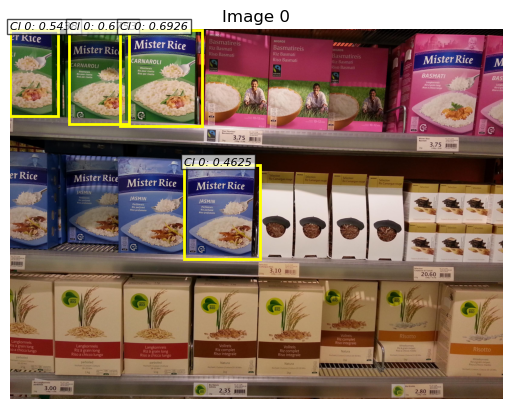

In [59]:
lcp.debug_for_test_vision(
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg = cfg,
    count = 2
)

### ÈÄôË£°Ë¶ÅË∑ë 62 minutes

In [ ]:
# for layer_name in layer_names:
#     lcp.prune_layer(
#         layer_name   = layer_name,
#         discard_rate = 0.8,
#     )

[LCP] ÈñãÂßãÂü∫ÊñºÊï∏Â≠∏Êé®Â∞éÁöÑÁÑ°Ê¢ØÂ∫¶ÈÄöÈÅìÈáçË¶ÅÊÄßË®àÁÆó - net_feature_maps.layer1.0.conv1
[LOG] ÂéüÂßãÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] Ââ™ÊûùÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] ÂéüÂßãÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] Ââ™ÊûùÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] ÂéüÂßãÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LOG] Ââ™ÊûùÁ∂≤Ë∑ØÁâπÂæµÊèêÂèñÂÆåÊàê
[LCP] Âü∫ÊñºÊï∏Â≠∏Êé®Â∞éÁöÑÁÑ°Ê¢ØÂ∫¶Ë®àÁÆóÂÆåÊàê
layer layer1.0.conv1 , È†êË®à‰øùÁïôÈÄöÈÅìÊï∏Èáè: 13/64, È†êË®àÊç®Ê£ÑÈÄöÈÅìÊï∏Èáè: 51/64
[1, 4, 7, 13, 14, 24, 29, 44, 53, 54, 60, 62, 63]
<class 'list'>
[1, 4, 7, 13, 14, 24, 29, 44, 53, 54, 60, 62, 63]
[INFO] Ê∑ªÂä†Êñ∞Â±§Á¥öÊï∏Êìö: net_feature_maps.layer1.0.conv1
[PRUNE] ÈñãÂßãÂâ™ÊûùÂ±§Á¥ö: layer1.0.conv1
=== net_feature_maps Ë©≥Á¥∞Â±§Á¥öË≥áË®ä ===
[LCP] Â±§Á¥ö‰æùË≥¥ÂàÜÊûêÂÆåÊàê - layer1.0.conv1
      BatchNorm: net_feature_maps.layer1.0.bn1
      ‰∏ãÊ∏∏Â±§Á¥ö: 1 ÂÄã
      Ë∑≥Ë∫çÈÄ£Êé•: 0 ÂÄã
[PRUNE] ÈñãÂßãÂâ™ÊûùËº∏Âá∫ÈÄöÈÅì: layer1.0.conv1
[PRUNE] ‰øùÁïôÈÄöÈÅìÁ¥¢Âºï: [1, 4, 7, 13, 14, 24, 29, 44, 53, 54, 60, 62, 63]
[PRUN

In [61]:
print( lcp._prune_net )

Os2dModel(
  (net_feature_maps): ResNetFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 13, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(13, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(13, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

#### Test for debug for vision after prune

image to show size: (3264, 2448), res


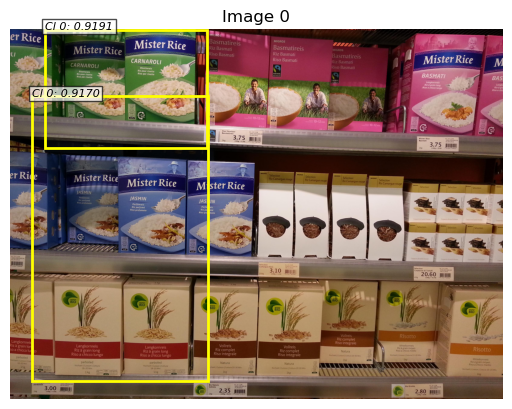

In [63]:
lcp.debug_for_test_vision(
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg = cfg,
    count = 1
)

In [ ]:
import torch

def count_parameters(model):
    """
    Ë®àÁÆóÊ®°ÂûãÁöÑÂèÉÊï∏Êï∏Èáè
    Returns:
      total_params: ÂåÖÂê´ÊâÄÊúâÂèÉÊï∏
      trainable_params: Âè™ÂåÖÂê´ requires_grad=True ÁöÑÂèÉÊï∏
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

import io

def estimate_model_size(model):
    """
    Â∞áÊ®°ÂûãÂ∫èÂàóÂåñÂà∞Á∑©Ë°ùÂçÄÔºå‰º∞ÁÆóÂ≠òÊ™îÂ§ßÂ∞èÔºàMBÔºâ
    """
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    size_mb = buffer.getbuffer().nbytes / (1024 ** 2)
    return size_mb



Á∏ΩÂèÉÊï∏Èáè: 3,235,365
ÂèØË®ìÁ∑¥ÂèÉÊï∏Èáè: 3,235,365
Ê®°ÂûãÂ≠òÂÑ≤Â§ßÂ∞è: 12.57 MB


In [68]:
# ‰ΩøÁî®ÁØÑ‰æã
print( "ÂéüÂßãÁ∂≤Ë∑ØÂèÉÊï∏Áµ±Ë®à:\n" )
model = lcp._net  # Â∑≤Ââ™ÊûùÁöÑÁ∂≤Ë∑Ø
total, trainable = count_parameters(model)
print(f"Á∏ΩÂèÉÊï∏Èáè: {total:,}")
print(f"ÂèØË®ìÁ∑¥ÂèÉÊï∏Èáè: {trainable:,}")

size_mb = estimate_model_size(model)
print(f"Ê®°ÂûãÂ≠òÂÑ≤Â§ßÂ∞è: {size_mb:.2f} MB")

print( "Ââ™ÊûùÁ∂≤Ë∑ØÂèÉÊï∏Áµ±Ë®à:\n" )
model = lcp._prune_net  # Â∑≤Ââ™ÊûùÁöÑÁ∂≤Ë∑Ø
total, trainable = count_parameters(model)
print(f"Á∏ΩÂèÉÊï∏Èáè: {total:,}")
print(f"ÂèØË®ìÁ∑¥ÂèÉÊï∏Èáè: {trainable:,}")

size_mb = estimate_model_size(model)
print(f"Ê®°ÂûãÂ≠òÂÑ≤Â§ßÂ∞è: {size_mb:.2f} MB")

ÂéüÂßãÁ∂≤Ë∑ØÂèÉÊï∏Áµ±Ë®à:

Á∏ΩÂèÉÊï∏Èáè: 10,169,478
ÂèØË®ìÁ∑¥ÂèÉÊï∏Èáè: 10,169,478
Ê®°ÂûãÂ≠òÂÑ≤Â§ßÂ∞è: 39.05 MB
Ââ™ÊûùÁ∂≤Ë∑ØÂèÉÊï∏Áµ±Ë®à:

Á∏ΩÂèÉÊï∏Èáè: 3,235,365
ÂèØË®ìÁ∑¥ÂèÉÊï∏Èáè: 3,235,365
Ê®°ÂûãÂ≠òÂÑ≤Â§ßÂ∞è: 12.57 MB


### Test for finetune

In [69]:
from src.lcp.lcpfinetune import LCPFineTune
lcp_finetune = LCPFineTune(
    prune_net = lcp._prune_net,
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg       = cfg,
    optimizer=optimizer,
    parameters=parameters
)

In [70]:
lcp_finetune._setup_logging()

In [73]:
batch_data = lcp_finetune.get_batch_data( 0 )

Image 0 size FeatureMapSize(w=3264, h=2448) has 30 boxes
Image 1 size FeatureMapSize(w=2448, h=3264) has 28 boxes
Image 2 size FeatureMapSize(w=3264, h=2448) has 35 boxes
Image 3 size FeatureMapSize(w=2448, h=3264) has 22 boxes


In [77]:
data = lcp_finetune.prepare_batch_data_for_finetune( batch_data )

[2025-07-10 17:20:00,958] [LCP.FineTune] [INFO] 4 imgs, 15 classes


In [75]:
lcp_finetune.shuffle_dataloader()